## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost

## Loading dataset

In [ ]:
acid_data = pd.read_csv('/content/Data_Acid.csv', encoding= 'unicode_escape')
acid_data = acid_data[:99]

In [ ]:
print('number of rows:',acid_data.shape[0],'number of columns:',acid_data.shape[1])

number of rows: 99 number of columns: 9


In [ ]:
acid_data.head()

,Reacion_Rate(1/min),HCl_%W(weight percent),Perm_mean(md),Porosity_mean,Qinjection(cc/min),So,Temprature©,Pressure(Kpa),PVBT
0,69.5,1.806303,1.4,0.175,1.0,0.0,22.0,2108.0,1.664198
1,69.5,1.806303,100.0,0.175,5.0,0.0,22.0,6895.0,23.448109
2,300.0,8.712788,1.4,0.175,0.3,0.5,40.0,6895.0,0.907701
3,69.5,8.712788,1.4,0.175,10.0,0.7,22.0,6895.0,1.009380
4,69.5,1.806303,1.4,0.175,0.3,0.0,22.0,6895.0,2.420594


In [ ]:
acid_data.describe()

,Reacion_Rate(1/min),HCl_%W(weight percent),Perm_mean(md),Porosity_mean,Qinjection(cc/min),So,Temprature©,Pressure(Kpa),PVBT
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,961.330202,11.262355,14.705051,0.187121,16.881818,0.214394,33.545455,6218.696970,15.496627
std,2716.800425,15.503562,71.097289,0.050174,33.041311,0.232639,21.885730,3550.710088,71.864017
min,4.210000,1.357832,0.500000,0.100000,0.200000,0.000000,10.000000,770.000000,0.050106
25%,23.600000,1.806303,1.400000,0.175000,0.800000,0.000000,22.000000,6895.000000,0.603908
50%,69.500000,1.806303,1.400000,0.175000,3.000000,0.000000,22.000000,6895.000000,2.017020
75%,203.000000,15.000000,1.400000,0.175000,10.000000,0.487500,40.000000,6895.000000,3.756203
max,14200.000000,62.367102,500.000000,0.500000,200.000000,0.700000,100.000000,30000.000000,630.354010


## Plotting features vs target column before removing outlier

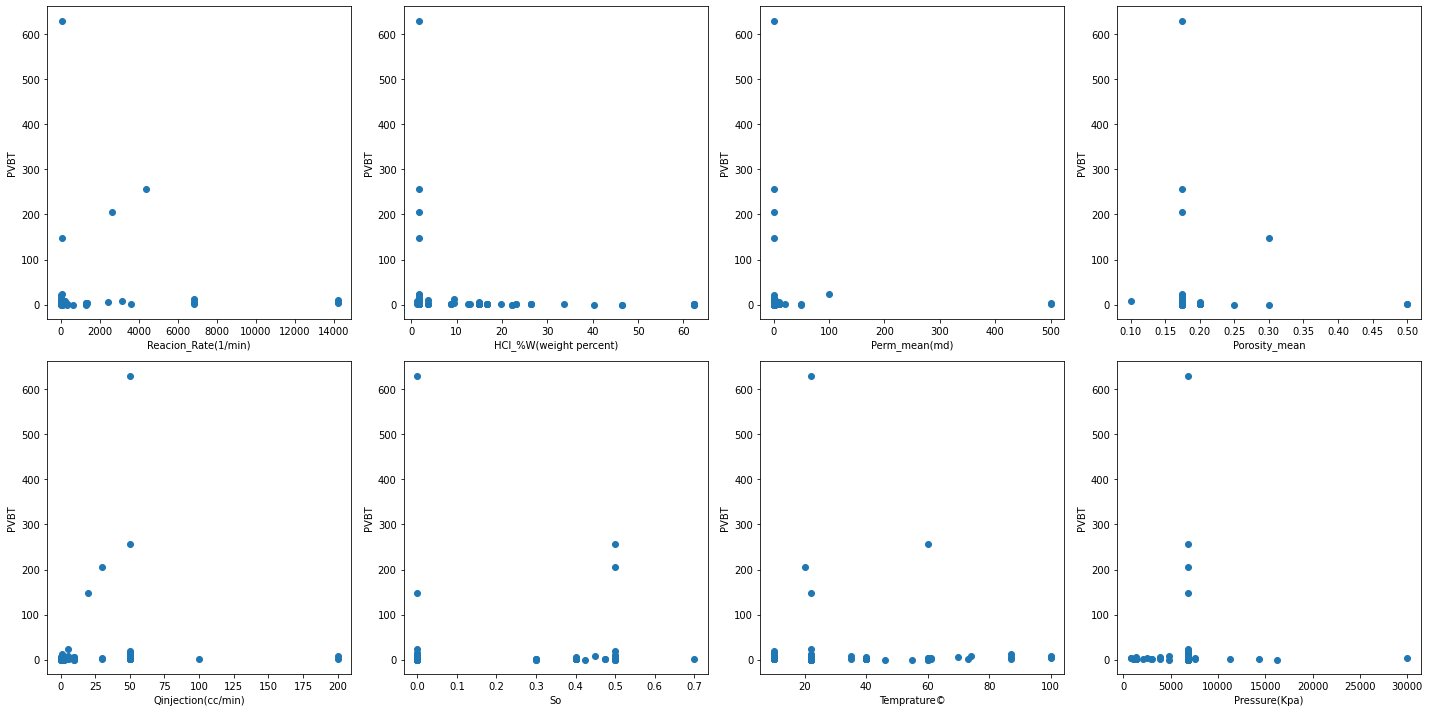

In [ ]:
plt.figure(figsize=(20,10))
for index,col in enumerate(acid_data):
  if col == 'PVBT':
    break
  plt.subplot(2,4,index+1)
  plt.scatter(acid_data[col], acid_data['PVBT'])
  plt.xlabel(col)
  plt.ylabel('PVBT')
plt.tight_layout()  
plt.show()

## Handling outliers

Outliers are extreme values that fall a long way outside of the other observations. In a small dataset, the impact of an outlier can be much greater, since it will have a heavy weight for the model:

In [ ]:
# IQR
Q1 = np.percentile(acid_data['PVBT'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(acid_data['PVBT'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", acid_data.shape)
 
# Upper bound
upper = np.where(acid_data['PVBT'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(acid_data['PVBT']<= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
acid_data.drop(upper[0], inplace = True)
acid_data.drop(lower[0], inplace = True)
 
print("New Shape: ", acid_data.shape)

Old Shape:  (99, 9)
New Shape:  (88, 9)


## Plotting features vs target column after removing outlier

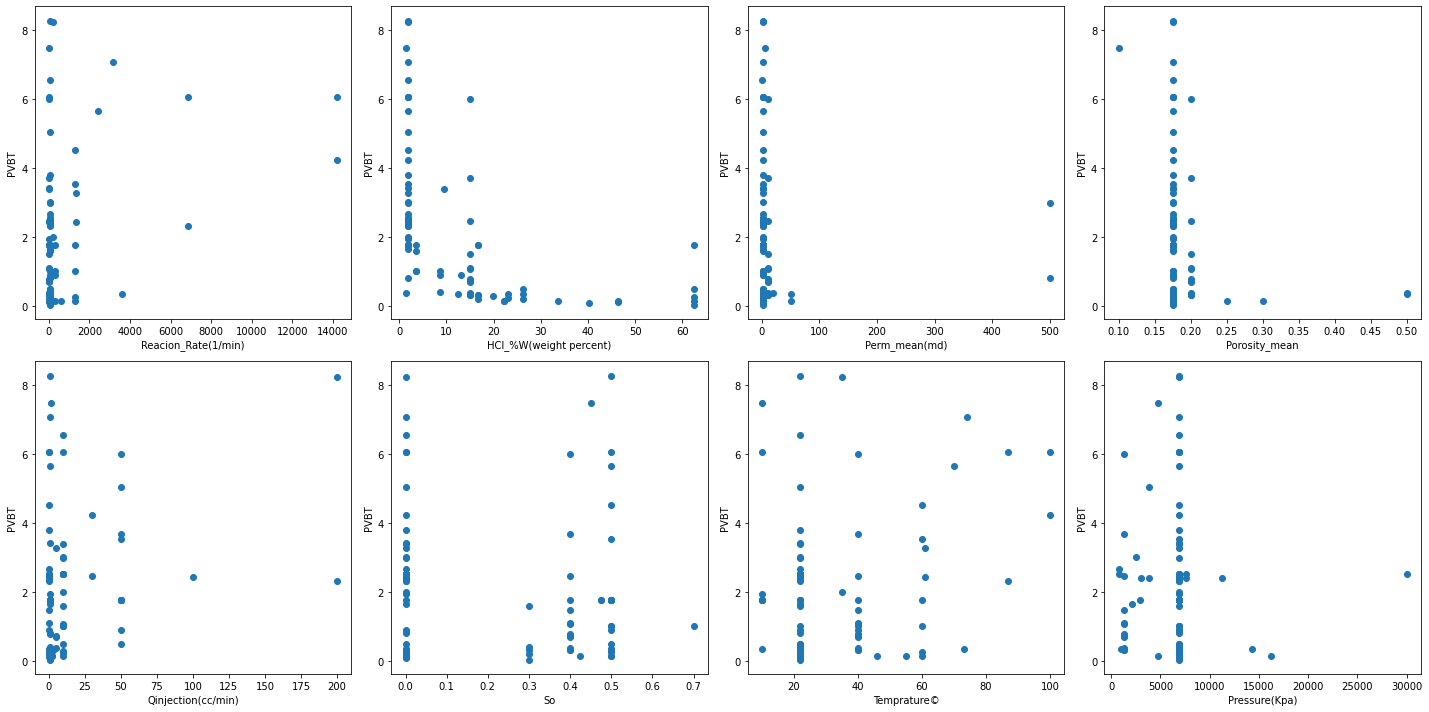

In [ ]:
plt.figure(figsize=(20,10))
for index,col in enumerate(acid_data):
  if col == 'PVBT':
    break
  plt.subplot(2,4,index+1)
  plt.scatter(acid_data[col], acid_data['PVBT'])
  plt.xlabel(col)
  plt.ylabel('PVBT')
plt.tight_layout()  
plt.show()

## Correlation and Finding important features

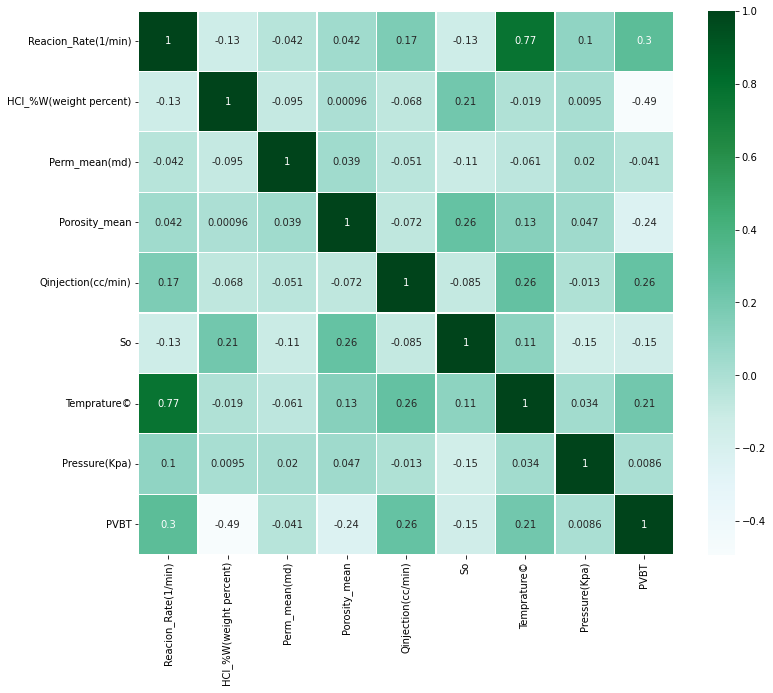

In [ ]:
plt.figure(figsize=(12,10))
corrmat = acid_data.corr()
sns.heatmap(corrmat, annot=True, linewidth=0.3, cmap="BuGn")
plt.show()

In [ ]:
print('importance order of features based on pearson correlation:\n')
cor = abs(corrmat['PVBT']).sort_values(ascending=False)[1:]
cor

importance order of features based on pearson correlation:



HCl_%W(weight percent)    0.492173
Reacion_Rate(1/min)       0.301665
Qinjection(cc/min)        0.258020
Porosity_mean             0.235805
Temprature©               0.207484
So                        0.146456
Perm_mean(md)             0.040691
Pressure(Kpa)             0.008573
Name: PVBT, dtype: float64

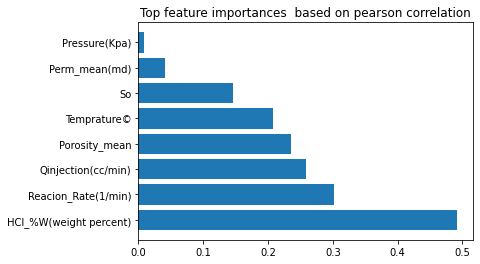

In [ ]:
plt.figure()
plt.title('Top feature importances  based on pearson correlation')
plt.barh(
    range(8), 
    cor.values,
)
plt.yticks(range(8), cor.index)
plt.show()

In [ ]:
X = acid_data.drop(['PVBT'], axis=1)
y = acid_data['PVBT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print('train shape: ', X_train.shape)
print('test shape: ', X_test.shape)

train shape:  (70, 8)
test shape:  (18, 8)


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

forest = ExtraTreesRegressor(n_estimators=250, max_depth=5, random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print('importance order of features based on ExtraTreesRegressor:\n')
for f in range(8):
    print('%d. feature %s (%f)' % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))


importance order of features based on ExtraTreesRegressor:

1. feature HCl_%W(weight percent) (0.519970)
2. feature Qinjection(cc/min) (0.168892)
3. feature Porosity_mean (0.099465)
4. feature Temprature© (0.058175)
5. feature hcl_react (0.051767)
6. feature Reacion_Rate(1/min) (0.049159)
7. feature Pressure(Kpa) (0.021266)
8. feature Perm_mean(md) (0.018250)


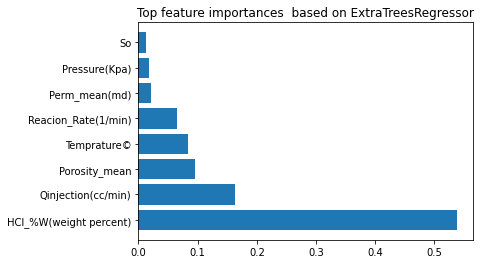

In [ ]:
plt.figure()
plt.title('Top feature importances  based on ExtraTreesRegressor')
plt.barh(
    range(8), 
    importances[indices],
)
plt.yticks(range(8), X_train.columns[indices])
plt.show()

## Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

### Linear regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
pred_lr_train = lr.predict(X_train_scaled)
pred_lr = lr.predict(X_test_scaled)
mean_squared_error(y_test, pred_lr, squared=False)

print('RMSE of train (LR):',mean_squared_error(y_train, pred_lr_train, squared=False))
print('RMSE of test (LR):',mean_squared_error(y_test, pred_lr, squared=False))

RMSE of train (LR): 1.6575910520820047
RMSE of test (LR): 1.663926061897407


### XGBoost Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

xgbr = XGBRegressor(random_state=42)
parameters = {'max_depth': [i for i in np.arange(2,10,1)],
              'gamma' : [0.5,0.7,1,1.5,2],
              # 'eta' : [i for i in np.arange(0.1,1,0.1)],
              #'reg_alpha' : [i for i in np.arange(0.1,1,0.1)],
              #'reg_lambda' : [i for i in np.arange(0.1,1,0.1)],
              # 'colsample_bytree': [i for i in np.arange(0.1,1,0.1)],
               'n_estimators': [i for i in np.arange(100,600,100)],
              'max_features' : ['sqrt', 'log2', 3, 5,7]
              # 'learning_rate': [0.001,0.01,0.1,0.5,1]

              }
clf = GridSearchCV(xgbr, parameters, cv=5, verbose=0)
clf.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:48] WARNING: /workspace/src/objective/regression_obj.

GridSearchCV(cv=5, estimator=XGBRegressor(random_state=42),
             param_grid={'gamma': [0.5, 0.7, 1, 1.5, 2],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2', 3, 5, 7],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [ ]:
print('best parameters are:\n',clf.best_params_)

best parameters are:
 {'gamma': 2, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}


In [ ]:
pred_xgbr_train = clf.best_estimator_.predict(X_train)
print('RMSE of train (XGBR):',mean_squared_error(y_train, pred_xgbr_train, squared=False))

RMSE of train (XGBR): 1.1332139433067188


In [ ]:
clf.best_estimator_.save_model("xgb_model.json")
# load
# model2 = xgboost.XGBRegressor()
# model2.load_model("model_sklearn.json")

In [ ]:
pred_xgbr = clf.best_estimator_.predict(X_test)
print('RMSE of test (XGBR):',mean_squared_error(y_test, pred_xgbr, squared=False))

RMSE of test (XGBR): 1.2036368793198704


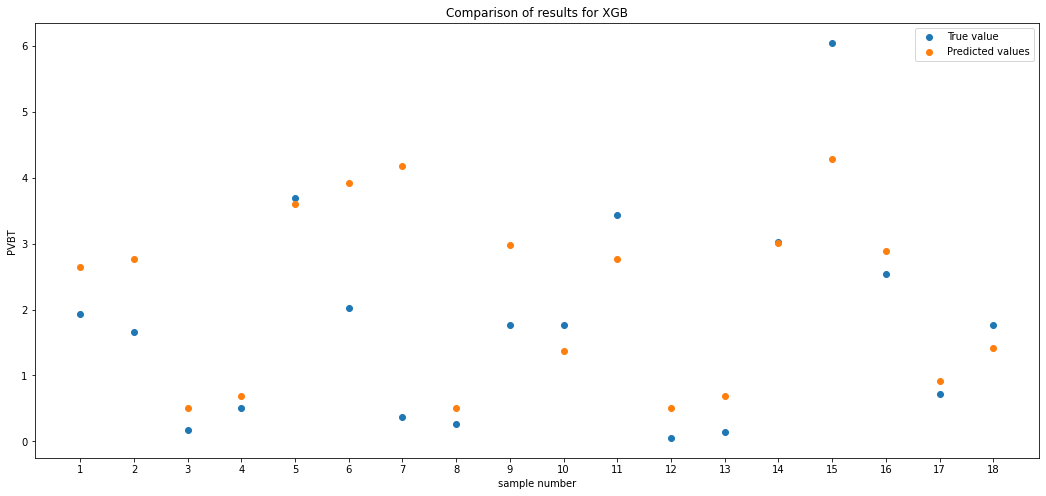

In [ ]:
pred_xgbr_data = clf.best_estimator_.predict(X_test)
plt.figure(figsize=(18,8))
plt.scatter(range(1,len(y_test)+1), y_test, label='True value')
plt.scatter(range(1,len(pred_xgbr_data)+1), pred_xgbr_data, label='Predicted values')
plt.title('Comparison of results for XGB')
plt.xlabel('sample number')
plt.ylabel('PVBT')
plt.xticks(range(1,len(y_test)+1))
plt.legend()
plt.show()

## Simple Nueral Network

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
x_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))

In [ ]:
x_train.shape

(70, 8, 1)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = keras.Sequential([
    layers.Input((8,1)),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8, 128)            256       
                                                                 
 dense_1 (Dense)             (None, 8, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 8, 32)             2080      
                                                                 
 dense_3 (Dense)             (None, 8, 16)             528       
                                                                 
 dense_4 (Dense)             (None, 8, 8)              136       
                                                                 
 dense_5 (Dense)             (None, 8, 1)              9         
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-traina

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanAbsoluteError(),
    metrics= keras.metrics.RootMeanSquaredError()
)

In [ ]:
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
3/3 - 0s - loss: 1.7147 - root_mean_squared_error: 2.4874 - 33ms/epoch - 11ms/step
Epoch 2/100
3/3 - 0s - loss: 1.6668 - root_mean_squared_error: 2.4007 - 26ms/epoch - 9ms/step
Epoch 3/100
3/3 - 0s - loss: 1.7025 - root_mean_squared_error: 2.4280 - 22ms/epoch - 7ms/step
Epoch 4/100
3/3 - 0s - loss: 1.6527 - root_mean_squared_error: 2.3497 - 36ms/epoch - 12ms/step
Epoch 5/100
3/3 - 0s - loss: 1.6743 - root_mean_squared_error: 2.4024 - 23ms/epoch - 8ms/step
Epoch 6/100
3/3 - 0s - loss: 1.6733 - root_mean_squared_error: 2.3792 - 31ms/epoch - 10ms/step
Epoch 7/100
3/3 - 0s - loss: 1.6293 - root_mean_squared_error: 2.3086 - 34ms/epoch - 11ms/step
Epoch 8/100
3/3 - 0s - loss: 1.6362 - root_mean_squared_error: 2.2926 - 33ms/epoch - 11ms/step
Epoch 9/100
3/3 - 0s - loss: 1.6324 - root_mean_squared_error: 2.3131 - 27ms/epoch - 9ms/step
Epoch 10/100
3/3 - 0s - loss: 1.6550 - root_mean_squared_error: 2.3465 - 25ms/epoch - 8ms/step
Epoch 11/100
3/3 - 0s - loss: 1.6135 - root_mean_squar

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 1.3047 - root_mean_squared_error: 1.6966


[1.3046765327453613, 1.696586012840271]

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(max_features='sqrt',min_samples_leaf=5 , validation_fraction=0.1, random_state=42)
gbr.fit(X_train, y_train)
pred_gbr_train = gbr.predict(X_train)
pred_gbr = gbr.predict(X_test)
mean_squared_error(y_test, pred_gbr, squared=False)

print('RMSE of train (GBR):',mean_squared_error(y_train, pred_gbr_train, squared=False))
print('RMSE of test (GBR):',mean_squared_error(y_test, pred_gbr, squared=False))

RMSE of train (GBR): 0.9662172060963128
RMSE of test (GBR): 0.9752846304760786


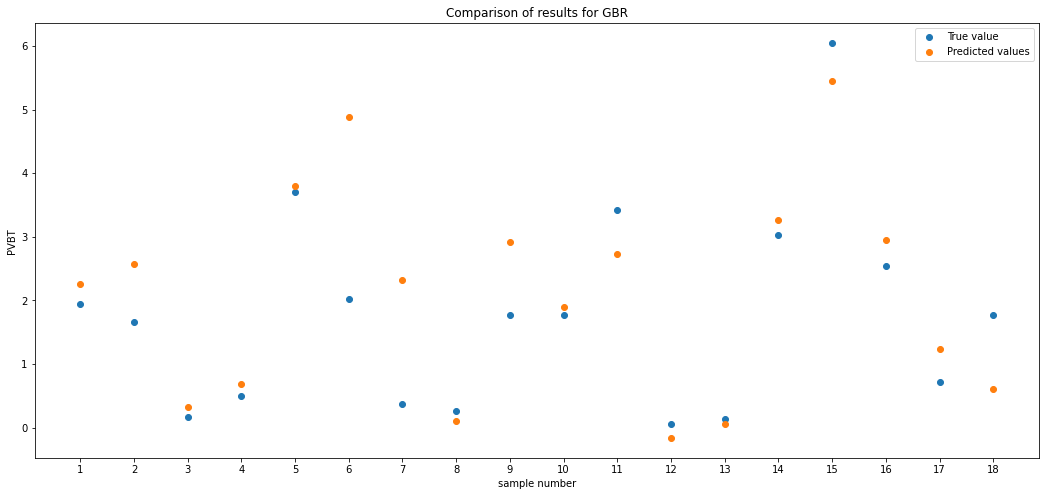

In [ ]:
plt.figure(figsize=(18,8))
plt.scatter(range(1,len(y_test)+1), y_test, label='True value')
plt.scatter(range(1,len(pred_gbr)+1), pred_gbr, label='Predicted values')
plt.title('Comparison of results for GBR')
plt.xlabel('sample number')
plt.ylabel('PVBT')
plt.xticks(range(1,len(y_test)+1))
plt.legend()
plt.show()